# **Import Libraries + Configurations**

In [62]:
# Libraries
import os
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import soundfile as sf
import librosa

from tqdm.auto import tqdm

# sklearn
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Hugging Face Hub & Kaggle
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
from huggingface_hub import HfApi

# Configs
SEED: int = 42
BATCH_SIZE: int = 64
NUM_CLASSES: int = 10
PATIENCE: int = 10
EPOCHS: int = 100

# Paths
ROOT_DIR   = "/kaggle/working/preprocessed/features_mel"
META_PATH  = "/kaggle/input/birdclef-2024/train_metadata.csv"
DATA_DIR: Path = Path("/kaggle/input/birdclef-2024")
OUT_DIR: Path = Path("/kaggle/working/preprocessed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

AUDIO_DIR: Path = DATA_DIR / "train_audio"

# Audio parameters
SR: int = 32000             # target sampling rate
TARGET_SEC: float = 5.0     # clip length in seconds

# STFT / Mel specs
N_FFT: int = 2048           # FFT window size (~64 ms at 32 kHz)
HOP: int = 512              # hop length (~16 ms)
N_MELS: int = 128           # mel bands

# Classes & dataset splits
TOP_N: int = NUM_CLASSES
TRAIN_PCT: float = 0.70
VAL_PCT: float = 0.15
TEST_PCT: float = 0.15

# Augmentation hyperparameters
MAX_PITCH_STEPS: float = 2.0
STRETCH_MIN: float = 0.85
STRETCH_MAX: float = 1.15
NOISE_STD: float = 0.005

# Functions

In [2]:
# Extract XC ID from metadata filename
def extract_xc(filename):
    name = filename.split("/")[-1]      # take last part (e.g., "XC12345_1.ogg")
    name = name.split(".")[0]           # remove extension
    name = name.split("_")[0]           # remove trailing _1, _2, etc.
    return name

# Load Train / Val / Test Split
def load_split(split_name):
    # Paths
    split_folder = os.path.join(ROOT_DIR, split_name)
    mel_files = [f for f in os.listdir(split_folder) if f.endswith(".npy")]
    rows = []

    for f in tqdm(mel_files, desc=f"Loading {split_name}"):
        base = f.split(".")[0]          # remove extension
        xc_id = base.split("_")[0]      # extract XCxxxxxx

        mel_path = os.path.join(split_folder, f)
        mel = np.load(mel_path)

        # match metadata entry
        row = meta.loc[meta["xc_id"] == xc_id]
        if row.empty:
            continue

        label = row["primary_label"].values[0]
        rows.append((mel, label, xc_id))

    return pd.DataFrame(rows, columns=["mel", "label", "xc_id"])

# Convert DataFrame → NumPy Arrays
def df_to_numpy(df):
    X = np.stack(df["mel"].values)     # (N, H, W)
    y = df["label_id"].to_numpy()      # (N,)
    return X, y

# Set All Random Seeds (Deterministic Runs)
def set_all_seeds(seed):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch CPU & GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    # multi-GPU

    # cuDNN deterministic mode
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Classes

In [106]:
# Dataset Class
class BirdSongDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()

        # Add channel dimension: (N, H, W) → (N, 1, H, W)
        X = X[:, None, :, :]

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __getitem__(self, idx):
        mel = self.X[idx]

        # Normalize each mel spectrogram individually
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        return mel, self.y[idx]

    def __len__(self):
        return len(self.X)


# VGG19 Model (1-channel version)
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # ---------- Block 1 ----------
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # ---------- Block 2 ----------
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # ---------- Block 3 ----------
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # ---------- Block 4 ----------
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # ---------- Block 5 ----------
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # replaces flatten
        
        # ----------- Classifier -----------
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        
            nn.Linear(64, num_classes)
        )
        
        # ----------- He Initialization ONLY for Hidden Classifier Layers -----------
        def init_classifier_he(m):
            if isinstance(m, nn.Linear) and m.out_features in [128, 64]:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
        self.classifier.apply(init_classifier_he)


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)        # [B, 512, 1, 1]
        x = torch.flatten(x, 1)   # [B, 512]
        x = self.classifier(x)
        return x

# Seed for reproducibility

In [107]:
set_all_seeds(SEED)

# Hugging Face

In [5]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

print("Logged in to Hugging Face!")

Logged in to Hugging Face!


# **Load metadata + Choose Top-N classes**

In [6]:
df = pd.read_csv(DATA_DIR / 'train_metadata.csv')
# value_counts() counts how many rows for each species (i.e., frequency of each label).
# By default value_counts sorts descending so the most common labels come first.
counts = df['primary_label'].value_counts()

# nunique() prints how many distinct species appear in the dataset.
print("Total species:", df['primary_label'].nunique())
print("\nTop 30 species by frequency:")
print(counts.head(30))

Total species: 182

Top 30 species by frequency:
primary_label
hoopoe     500
grewar3    500
houspa     500
blrwar1    500
grnsan     500
comgre     500
graher1    500
litgre1    500
eurcoo     500
comkin1    500
lirplo     500
eucdov     500
eaywag1    500
woosan     500
zitcis1    500
barswa     500
bcnher     500
comros     500
commoo3    500
grywag     500
comsan     500
bkwsti     500
rorpar     420
litegr     405
comtai1    302
grtdro1    278
greegr     276
asikoe2    275
purher1    274
wemhar1    273
Name: count, dtype: int64


In [7]:
# Select the TOP_N most common species

# takes the top TOP_N most frequent species and stores their label names in selected.
selected = counts.head(TOP_N).index.tolist()
print(f"\nSelected top-{TOP_N} species: {selected}")

# Filter metadata to only include these classes

# filters the DataFrame to only rows whose primary_label is in the selected list (and .copy() makes an explicit copy to avoid SettingWithCopy warnings).
# Using .copy() is a good practice when you will modify the filtered DataFrame
filtered = df[df['primary_label'].isin(selected)].copy()

# filtered['filename'].notna() removes rows where filename is missing (ensures we only keep entries that have an audio file name).
# reset_index(drop=True) resets the DataFrame index (nice housekeeping so indices run 0..n-1 after filtering).
filtered = filtered[filtered['filename'].notna()].reset_index(drop=True) 

print("\nFiltered shape:", filtered.shape)
print("Class distribution in filtered:")
print(filtered['primary_label'].value_counts()) # The subsequent value_counts() prints the class distribution inside the filtered subset.


Selected top-10 species: ['hoopoe', 'grewar3', 'houspa', 'blrwar1', 'grnsan', 'comgre', 'graher1', 'litgre1', 'eurcoo', 'comkin1']

Filtered shape: (5000, 12)
Class distribution in filtered:
primary_label
blrwar1    500
comgre     500
comkin1    500
eurcoo     500
graher1    500
grewar3    500
grnsan     500
hoopoe     500
houspa     500
litgre1    500
Name: count, dtype: int64


# **Check missing files**

In [8]:
missing = []
for fn in filtered['filename'].unique():
    if not (AUDIO_DIR / fn).exists():
        missing.append(fn)

print("Missing audio files:", len(missing))
if len(missing) > 0:
    print("Example missing:", missing[:10])
else:
    print("All audio files found.")

Missing audio files: 0
All audio files found.


# **Data Splitting based on Groups ("Author")**

# **Compute group IDs**

**This constructs an array called groups that will be used to split the data while keeping samples from the same group together (so the same author doesn’t appear in both train and validation sets). If author is missing, filename is used as a fallback group id. Group-aware splitting prevents data leakage when multiple examples from the same real-world source exist. GroupShuffleSplit (imported earlier) is the tool you’d typically use to perform such group-based splits. 
Scikit-learn**

In [9]:
# Use 'author' to avoid leakage between train/val/test
# If author is missing, use filename as fallback

groups = filtered['author'].fillna(filtered['filename']).values
print("Example groups:", groups[:10])

Example groups: ['Patrik Åberg' 'Edmunds Racinskis' 'Edmunds Racinskis'
 'Edmunds Racinskis' 'Antero Lindholm' 'Patrick Franke' 'Patrick Franke'
 'Lars Theng' 'Antero Lindholm' 'Albert Lastukhin']


# **Split 1: TrainVal / Test**

In [10]:
splitter1 = GroupShuffleSplit(
    n_splits=1, 
    test_size=TEST_PCT, 
    random_state=SEED
)

trainval_idx, test_idx = next(
    splitter1.split(
        filtered,
        filtered['primary_label'],
        groups
    )
)

trainval_df = filtered.iloc[trainval_idx].reset_index(drop=True)
test_df     = filtered.iloc[test_idx].reset_index(drop=True)

In [11]:
print("TrainVal shape:", trainval_df.shape)
print("Test shape:", test_df.shape)

TrainVal shape: (4005, 12)
Test shape: (995, 12)


# **Split 2: Train / Validation**

In [12]:
# val proportion relative to TrainVal only
val_rel = VAL_PCT / (1.0 - TEST_PCT)

splitter2 = GroupShuffleSplit(
    n_splits=1, 
    test_size=val_rel, 
    random_state=SEED
)

groups_trainval = trainval_df['author'].fillna(trainval_df['filename']).values

train_idx_rel, val_idx_rel = next(
    splitter2.split(
        trainval_df,
        trainval_df['primary_label'],
        groups_trainval
    )
)

train_df = trainval_df.iloc[train_idx_rel].reset_index(drop=True)
val_df   = trainval_df.iloc[val_idx_rel].reset_index(drop=True)

In [13]:
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (3037, 12)
Val shape: (968, 12)


# **Save splits + sanity checks**

In [14]:
train_df.to_csv(OUT_DIR / 'train_meta_top10.csv', index=False)
val_df.to_csv(OUT_DIR / 'val_meta_top10.csv', index=False)
test_df.to_csv(OUT_DIR / 'test_meta_top10.csv', index=False)

In [15]:
print("Saved train/val/test metadata!")

print("\nPer-class counts — TRAIN:")
print(train_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — VALIDATION:")
print(val_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — TEST:")
print(test_df['primary_label'].value_counts().sort_index())

# Makeup check
print("\nCheck total rows:",
      len(train_df) + len(val_df) + len(test_df),
      "== filtered size:", len(filtered))

Saved train/val/test metadata!

Per-class counts — TRAIN:
primary_label
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
Name: count, dtype: int64

Per-class counts — VALIDATION:
primary_label
blrwar1     60
comgre      80
comkin1    178
eurcoo      72
graher1     98
grewar3     53
grnsan     106
hoopoe     123
houspa     121
litgre1     77
Name: count, dtype: int64

Per-class counts — TEST:
primary_label
blrwar1     91
comgre      98
comkin1    102
eurcoo     103
graher1     83
grewar3     84
grnsan      83
hoopoe     120
houspa     129
litgre1    102
Name: count, dtype: int64

Check total rows: 5000 == filtered size: 5000


# **Preprocess + Feature Extraction + Augmentation Funs**

In [16]:
# Load audio (mono), resample, pad/crop to target_sec and RMS-normalize.
def load_and_fix_length(path, sr=SR, target_sec=TARGET_SEC):
    y, _sr = sf.read(path) 
    # Reads the audio file at path into a NumPy array y and returns the file’s original sample rate _sr.
    #This uses the PySoundFile (soundfile) library which returns NumPy arrays.
    
    # Convert to mono (from 2 channels to one channel)
    if y.ndim > 1:
        # y = y.mean(axis=1)
        y = librosa.to_mono(y.T) # y.T converts from (n_samples, n_channels) → (n_channels, n_samples),
    
    # Resampling: if the original sample rate _sr differs from desired sr (e.g. 44100 → 32000), resample the waveform to sr.
    # This uses librosa.resample which performs high-quality band-limited resampling. 
    # Resampling ensures all examples have the same temporal resolution for later features.
    if _sr != sr:
        y = librosa.resample(y.astype('float32'), orig_sr=_sr, target_sr=sr)
    
    # Compute the target number of samples for target_sec seconds (e.g. 32000 * 5 = 160000 samples).
    target_len = int(sr * target_sec)

    # Padding
    # Pad short audio with zeros at the end so every clip becomes target_len.
    # np.pad with mode='constant' fills zeros; useful because most neural nets need fixed-length inputs.
    if len(y) < target_len:
        pad = target_len - len(y)
        y = np.pad(y, (0, pad), mode='constant')

    # Crop long audio: instead of taking a fixed slice, it performs a random crop — that adds data 
    # variability/augmentation during preprocessing (different crops across epochs → more robustness).
    elif len(y) > target_len:
        # random crop for variability
        start = np.random.randint(0, len(y)-target_len+1)
        y = y[start:start+target_len]

    # RMS normalization
    # compute the root-mean-square (RMS) amplitude sqrt(mean(y^2)) and divide the signal by it so each clip has approximately the same average energy. 
    # Adding 1e-9 prevents division by zero for silent files. RMS (average-power) normalization is common when you want consistent loudness between samples (different from peak normalization).
    rms = np.sqrt(np.mean(y**2)) + 1e-9
    y = y / rms
    return y.astype('float32')

In [17]:
# Return log-mel (n_mels x frames) as float32.
def extract_log_mel(y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS):
    # librosa.feature.melspectrogram computes a Mel-scaled spectrogram from the waveform. With power=2.0, it computes a power spectrogram (energy; magnitude squared).
    # Mel scale compresses frequency bins to match human perception and is the standard input for many audio NN models.
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    
    # librosa.power_to_db converts the power spectrogram to decibels (log scale), which both compresses dynamic range and tends to work better for models than linear power.
    # It computes 10 * log10(S / ref) in a numerically stable way.
    logS = librosa.power_to_db(S, ref=np.max)
    return logS.astype('float32')

# **Extract original TRAIN log-mels directly into features_mel/Train**

In [18]:
# Ensure necessary vars exist
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
for d in (FEAT_DIR, train_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

orig_feat_csv = OUT_DIR / 'train_features_top10_original.csv'
orig_feat_records = []

if orig_feat_csv.exists():
    print("Original features CSV found — loading:", orig_feat_csv)
    orig_feat_df = pd.read_csv(orig_feat_csv)
    print("Rows loaded:", len(orig_feat_df))
else:
    print("No original features CSV found — extracting log-mel for train samples now...")
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
        fn = row['filename']
        path = AUDIO_DIR / fn
        try:
            y = load_and_fix_length(path)   # uses your existing helper
            m = extract_log_mel(y)          # uses your existing helper
            out_filename = Path(fn).stem + '.npy'
            out_path = train_dir / out_filename
            # skip if file already exists (idempotent)
            if not out_path.exists():
                np.save(out_path, m)
            orig_feat_records.append({
                'feature_path': str(out_path),
                'filename': fn,
                'primary_label': row['primary_label'],
                'is_augmented': 0
            })
        except Exception as e:
            print("Error on", fn, e)

    orig_feat_df = pd.DataFrame(orig_feat_records)
    orig_feat_df.to_csv(orig_feat_csv, index=False)
    print("Saved original train features metadata:", orig_feat_csv)
    print("Original train feature rows:", len(orig_feat_df))

No original features CSV found — extracting log-mel for train samples now...


  0%|          | 0/3037 [00:00<?, ?it/s]

Saved original train features metadata: /kaggle/working/preprocessed/train_features_top10_original.csv
Original train feature rows: 3037


# **Extract VALIDATION and TEST log-mels into separate subfolders**

In [19]:
# Ensure val_df / test_df present
assert 'val_df' in globals(), "val_df not found — run the split cells first"
assert 'test_df' in globals(), "test_df not found — run the split cells first"

FEAT_DIR = OUT_DIR / 'features_mel'
val_dir = FEAT_DIR / 'Validation'
test_dir = FEAT_DIR / 'Test'
for d in (FEAT_DIR, val_dir, test_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

# Validation
val_records = []
print("Extracting log-mel for validation set... total rows:", len(val_df))
for idx, row in tqdm(val_df.iterrows(), total=len(val_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_VAL.npy"
        out_path = val_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        val_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing validation file:", fn, e)

val_feat_df = pd.DataFrame(val_records)
val_csv = OUT_DIR / 'val_features_top10.csv'
val_feat_df.to_csv(val_csv, index=False)
print("Saved validation features CSV:", val_csv)
print("Validation features extracted:", len(val_feat_df))

# Test
test_records = []
print("Extracting log-mel for test set... total rows:", len(test_df))
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_TEST.npy"
        out_path = test_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        test_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing test file:", fn, e)

test_feat_df = pd.DataFrame(test_records)
test_csv = OUT_DIR / 'test_features_top10.csv'
test_feat_df.to_csv(test_csv, index=False)
print("Saved test features CSV:", test_csv)
print("Test features extracted:", len(test_feat_df))

Extracting log-mel for validation set... total rows: 968


  0%|          | 0/968 [00:00<?, ?it/s]

Saved validation features CSV: /kaggle/working/preprocessed/val_features_top10.csv
Validation features extracted: 968
Extracting log-mel for test set... total rows: 995


  0%|          | 0/995 [00:00<?, ?it/s]

Saved test features CSV: /kaggle/working/preprocessed/test_features_top10.csv
Test features extracted: 995


# **Augmentation**

In [20]:
# Apply one random augmentation: pitch / stretch / noise.
# Uses explicit librosa.effects calls to avoid shadowing issues.
def augment_audio(y, sr=SR):
    choice = random.choice(['pitch', 'stretch', 'noise'])
    if choice == 'pitch':
        steps = random.uniform(-MAX_PITCH_STEPS, MAX_PITCH_STEPS)
        try:
            y_aug = librosa.effects.pitch_shift(y.astype('float32'), sr, steps)
        except Exception:
            return y
        # keep same length
        if len(y_aug) < len(y):
            y_aug = np.pad(y_aug, (0, len(y)-len(y_aug)), mode='constant')
        else:
            y_aug = y_aug[:len(y)]
        return y_aug.astype('float32')

    elif choice == 'stretch':
        rate = random.uniform(STRETCH_MIN, STRETCH_MAX)
        try:
            y_st = librosa.effects.time_stretch(y.astype('float32'), rate)
        except Exception:
            return y
        if len(y_st) < len(y):
            y_st = np.pad(y_st, (0, len(y)-len(y_st)), mode='constant')
        else:
            y_st = y_st[:len(y)]
        return y_st.astype('float32')

    else:  # noise
        noise = np.random.normal(0, NOISE_STD, size=len(y)).astype('float32')
        return (y + noise).astype('float32')

# **Augment TRAIN set directly into features_mel/Train, save balanced CSV and class weights**

In [21]:
# Ensure train_df & orig_feat_df
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

orig_csv = OUT_DIR / 'train_features_top10_original.csv'
if Path(orig_csv).exists():
    orig_feat_df = pd.read_csv(orig_csv)
else:
    # If original CSV missing (maybe you ran cell1 but didn't save), try to build from files in Train dir
    train_dir = OUT_DIR / 'features_mel' / 'Train'
    orig_feat_df = []
    for p in Path(train_dir).glob('*.npy'):
        # Try to recover label from train_df by filename match
        fname = p.name
        # find corresponding filename in train_df
        match = train_df[train_df['filename'].apply(lambda x: Path(x).stem in fname)]
        label = match['primary_label'].iloc[0] if len(match) > 0 else ''
        orig_feat_df.append({'feature_path': str(p), 'filename': fname, 'primary_label': label, 'is_augmented': 0})
    orig_feat_df = pd.DataFrame(orig_feat_df)

# Directories
FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
train_dir.mkdir(parents=True, exist_ok=True)

# Determine target per-class
train_class_counts = train_df['primary_label'].value_counts()
TARGET_PER_CLASS = int(train_class_counts.max())
print("Target per class (max in train):", TARGET_PER_CLASS)

# Current original feature counts
curr_counts = orig_feat_df['primary_label'].value_counts().to_dict()
print("\nCurrent extracted original counts (may be <= train counts):")
print(pd.Series(curr_counts).sort_index())

aug_records = []
classes = sorted(train_df['primary_label'].unique())

print(f"\nAugmenting train only to reach {TARGET_PER_CLASS} samples per class (based on train_df)...")
for cls in tqdm(classes):
    curr = int(curr_counts.get(cls, 0))
    needed = TARGET_PER_CLASS - curr
    if needed <= 0:
        continue

    candidates = train_df[train_df['primary_label'] == cls]
    if candidates.empty:
        print("No train candidates for", cls, " — skipping.")
        continue

    sampled = candidates.sample(needed, replace=True, random_state=SEED).reset_index(drop=True)
    for _, row in sampled.iterrows():
        wav_path = AUDIO_DIR / row['filename']
        try:
            y = load_and_fix_length(wav_path)
            y_aug = augment_audio(y, SR)
            mel = extract_log_mel(y_aug)
            aug_stem = f"{Path(row['filename']).stem}_AUG_{random.randint(100000, 999999)}.npy"
            out_path = train_dir / aug_stem
            # ensure unique (very unlikely conflict)
            if out_path.exists():
                continue
            np.save(out_path, mel)
            aug_records.append({
                'feature_path': str(out_path),
                'filename': row['filename'],
                'primary_label': cls,
                'is_augmented': 1
            })
        except Exception as e:
            print("Error augmenting", wav_path, e)

aug_df = pd.DataFrame(aug_records)
print("Augmented feature rows created:", len(aug_df))

# Combine original + augmented -> balanced features CSV
# Make sure orig_feat_df feature_path points to Train dir files (if they are by filename)
def normalize_feature_path(p):
    if pd.isna(p) or p == '':
        return p
    p = Path(p)
    if p.exists():
        return str(p)
    # try to resolve by name inside train_dir
    candidate = train_dir / p.name
    if candidate.exists():
        return str(candidate)
    return str(p)

if 'feature_path' in orig_feat_df.columns:
    orig_feat_df['feature_path'] = orig_feat_df['feature_path'].apply(normalize_feature_path)

final_feat_df = pd.concat([orig_feat_df, aug_df], ignore_index=True).reset_index(drop=True)
balanced_csv = OUT_DIR / 'train_features_top10_balanced_by_maxclass.csv'
final_feat_df.to_csv(balanced_csv, index=False)
print("Saved balanced train features metadata:", balanced_csv)

# Final counts check and class weights
final_counts = final_feat_df['primary_label'].value_counts().sort_index()
print("\nFinal per-class counts (train) after augmentation:")
print(final_counts)

total = final_counts.sum()
class_weight = {label: (total / (len(final_counts) * int(cnt))) for label, cnt in final_counts.items()}
with open(OUT_DIR / 'class_weights_top10_by_maxclass.json', 'w') as f:
    json.dump(class_weight, f)
print("Saved class weights:", OUT_DIR / 'class_weights_top10_by_maxclass.json')

# Quick final distribution and plot
def count_npys(d):
    return len(list(Path(d).glob('*.npy')))

print("\nFinal distribution in subfolders:")
print(f" Train: {count_npys(train_dir)} files -> {train_dir}")
print(f" Validation: {count_npys(FEAT_DIR / 'Validation')} files -> {FEAT_DIR / 'Validation'}")
print(f" Test: {count_npys(FEAT_DIR / 'Test')} files -> {FEAT_DIR / 'Test'}")

Target per class (max in train): 363

Current extracted original counts (may be <= train counts):
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
dtype: int64

Augmenting train only to reach 363 samples per class (based on train_df)...


  0%|          | 0/10 [00:00<?, ?it/s]

Augmented feature rows created: 593
Saved balanced train features metadata: /kaggle/working/preprocessed/train_features_top10_balanced_by_maxclass.csv

Final per-class counts (train) after augmentation:
primary_label
blrwar1    363
comgre     363
comkin1    363
eurcoo     363
graher1    363
grewar3    363
grnsan     363
hoopoe     363
houspa     363
litgre1    363
Name: count, dtype: int64
Saved class weights: /kaggle/working/preprocessed/class_weights_top10_by_maxclass.json

Final distribution in subfolders:
 Train: 3630 files -> /kaggle/working/preprocessed/features_mel/Train
 Validation: 968 files -> /kaggle/working/preprocessed/features_mel/Validation
 Test: 995 files -> /kaggle/working/preprocessed/features_mel/Test


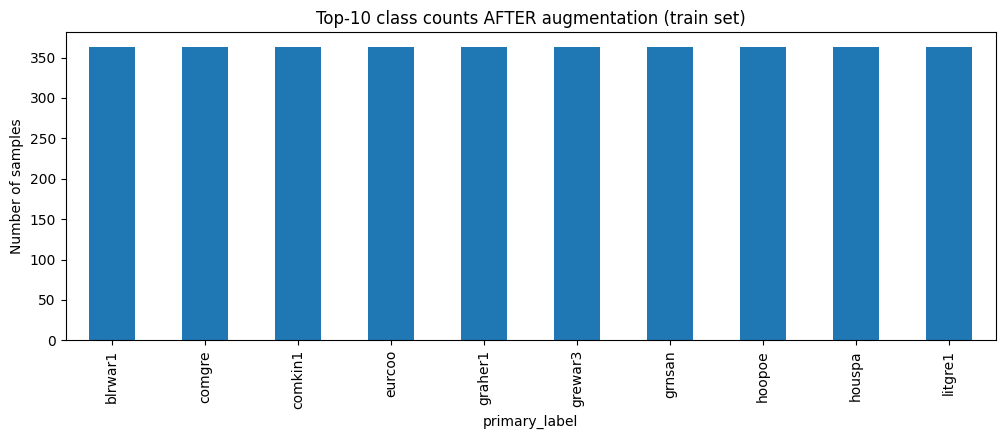

In [22]:
plt.figure(figsize=(12,4))
final_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Top-10 class counts AFTER augmentation (train set)")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.show()

# Model Preprocessing

In [108]:
# Load Metadata
meta = pd.read_csv(META_PATH)
meta["xc_id"] = meta["filename"].apply(extract_xc)

# Load Train / Val / Test Splits
df_train = load_split("Train")
df_val   = load_split("Validation")
df_test  = load_split("Test")

# Label Encoding
le = LabelEncoder()
le.fit(df_train["label"])

df_train["label_id"] = le.transform(df_train["label"])
df_val["label_id"]   = le.transform(df_val["label"])
df_test["label_id"]  = le.transform(df_test["label"])

# Convert DataFrames → NumPy
X_train, y_train = df_to_numpy(df_train)
X_val,   y_val   = df_to_numpy(df_val)
X_test,  y_test  = df_to_numpy(df_test)

# Dataset Wrappers
train_dataset      = BirdSongDataset(X_train, y_train)
validation_dataset = BirdSongDataset(X_val,   y_val)
test_dataset       = BirdSongDataset(X_test,  y_test)

# DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)


validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Loading Train:   0%|          | 0/3630 [00:00<?, ?it/s]

Loading Validation:   0%|          | 0/968 [00:00<?, ?it/s]

Loading Test:   0%|          | 0/995 [00:00<?, ?it/s]

# Train Model

**Configurations**

In [109]:
# Reproducibility
set_all_seeds(SEED)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
model = VGG19(num_classes=NUM_CLASSES).to(device)

# Loss Function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# Scheduler (reduces LR when validation loss stops improving)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,    # reduce LR by 50%
    patience=5   # wait 5 epochs with no improvement
)

**Training**

In [110]:
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# ===================== TRAINING LOOP =====================
for epoch in range(EPOCHS):

    # ---------- TRAIN ----------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)

        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in validation_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)

            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    # ---------- METRICS ----------
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss   = val_loss / len(validation_loader)

    train_accuracy = train_correct / train_total
    val_accuracy   = val_correct / val_total

    # Scheduler step ONCE per epoch
    scheduler.step(avg_val_loss)

    # ---------- SAVE HISTORY ----------
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # ---------- LOGGING ----------
    if epoch % 5 == 0:
        print(
            f"Epoch {epoch + 1:03d} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Train Acc: {train_accuracy:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_accuracy:.4f}"
        )

    # ---------- EARLY STOPPING ----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        break

Epoch 001 | Train Loss: 2.3260 | Train Acc: 0.1212 | Val Loss: 2.3208 | Val Acc: 0.0992
Epoch 006 | Train Loss: 1.4964 | Train Acc: 0.4683 | Val Loss: 1.4969 | Val Acc: 0.4855
Epoch 011 | Train Loss: 1.1312 | Train Acc: 0.6094 | Val Loss: 1.5194 | Val Acc: 0.5248
Epoch 016 | Train Loss: 0.8840 | Train Acc: 0.7132 | Val Loss: 1.2887 | Val Acc: 0.6002
Epoch 021 | Train Loss: 0.7371 | Train Acc: 0.7628 | Val Loss: 1.0708 | Val Acc: 0.6736
Epoch 026 | Train Loss: 0.6283 | Train Acc: 0.8030 | Val Loss: 0.9995 | Val Acc: 0.6921
Epoch 031 | Train Loss: 0.4786 | Train Acc: 0.8477 | Val Loss: 1.4801 | Val Acc: 0.5919
Epoch 036 | Train Loss: 0.2438 | Train Acc: 0.9292 | Val Loss: 1.1661 | Val Acc: 0.7056

Early stopping triggered at epoch 36


**Upload to HuggingFace**

In [116]:
torch.save(model.state_dict(), "final_model.pth")

api = HfApi()

api.upload_file(
    path_or_fileobj="final_model.pth",
    path_in_repo="final_model.pth",
    repo_id="abdelrahmane01/VGG19",
    repo_type="model"
)

print("✅ Model uploaded to Hugging Face successfully!")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Model uploaded to Hugging Face successfully!


**Loss Curve**

In [111]:
epochs = range(1, len(train_losses) + 1)

# ===================== BEST EPOCH FROM LOSS =====================
best_val_loss = min(val_losses)
best_epoch = val_losses.index(best_val_loss) + 1
best_val_acc_at_best_loss = val_accuracies[best_epoch - 1]

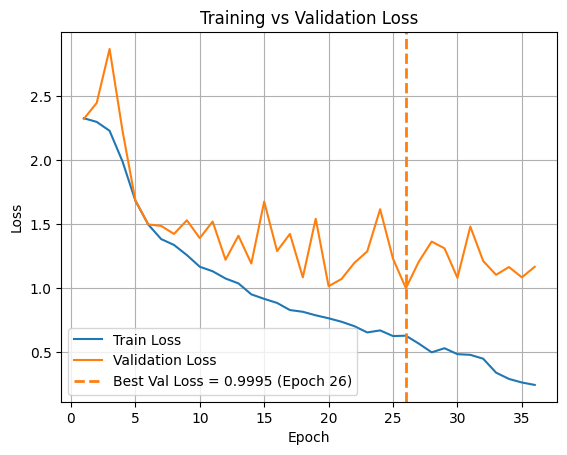

In [118]:
plt.figure()

plt.plot(epochs, train_losses, label="Train Loss")
val_line, = plt.plot(epochs, val_losses, label="Validation Loss")

plt.axvline(
    x=best_epoch,
    linestyle="--",
    linewidth=2,
    color=val_line.get_color(),
    label=f"Best Val Loss = {best_val_loss:.4f} (Epoch {best_epoch})"
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ✅ SAVE THE FIGURE
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")

plt.show()


**Accuracy Curve**

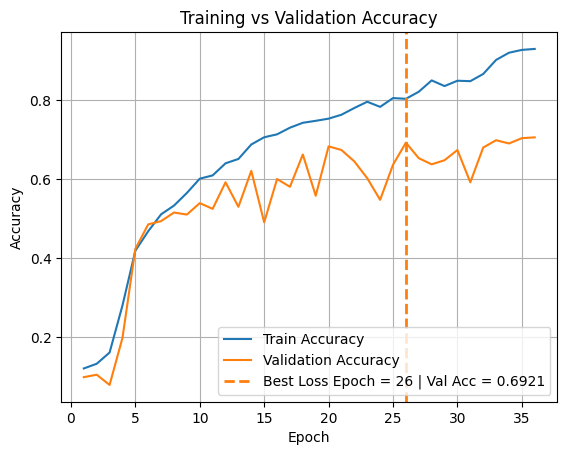

In [119]:
plt.figure()

plt.plot(epochs, train_accuracies, label="Train Accuracy")
val_line, = plt.plot(epochs, val_accuracies, label="Validation Accuracy")

plt.axvline(
    x=best_epoch,
    linestyle="--",
    linewidth=2,
    color=val_line.get_color(),
    label=f"Best Loss Epoch = {best_epoch} | Val Acc = {best_val_acc_at_best_loss:.4f}"
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# ✅ SAVE THE FIGURE
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches="tight")

plt.show()


# Evaluate Model

**Test Evaluation**

In [114]:
# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

**Classification Report**

In [115]:
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        91
           1       0.85      0.80      0.82        98
           2       0.85      0.74      0.79       102
           3       0.69      0.64      0.67       103
           4       0.60      0.64      0.62        83
           5       0.61      0.83      0.71        84
           6       0.61      0.75      0.67        83
           7       0.79      0.71      0.75       120
           8       0.85      0.78      0.81       129
           9       0.52      0.52      0.52       102

    accuracy                           0.70       995
   macro avg       0.70      0.70      0.70       995
weighted avg       0.72      0.70      0.71       995



**Confusion Matrix**

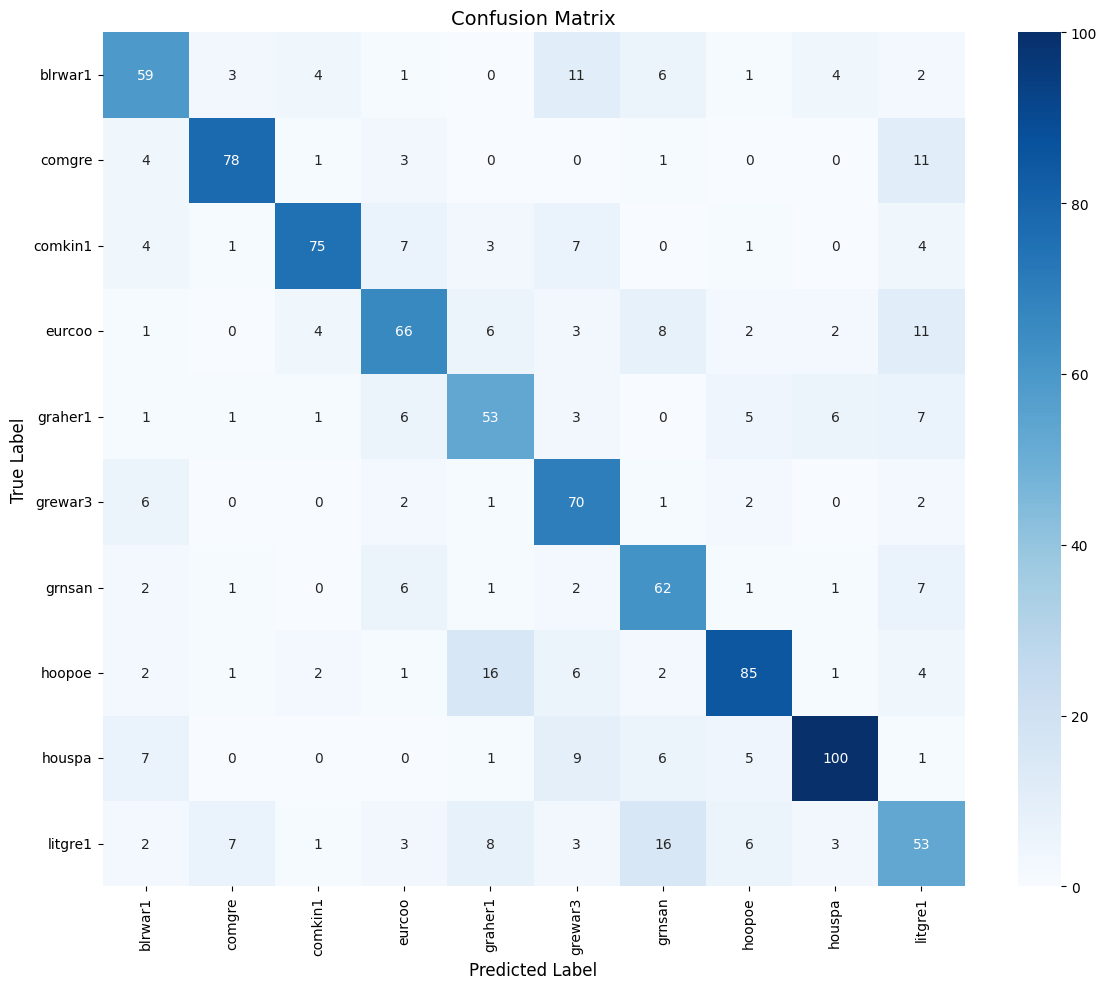

In [120]:
cm = confusion_matrix(all_targets, all_preds)

# Number of classes
num_classes = len(le.classes_)
class_names = le.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# ✅ SAVE THE FIGURE
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")

plt.show()
